# NLP Data Representation 

This activity will be divided into three parts. 
1. We're going to get some practice with n-gram language models.  
2. We'll investigate ways to try to improve the Naive Bayes classifier from last class using techniques we learned today!
3. We'll discuss ways we can do error analysis on the Naive Bayes classifier.

In [1]:
# Run this every time you open the notebook
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
! git clone https://github.com/heyyjudes/AI4ALL2021-NLP.git
! mv AI4ALL2021-NLP/data . 
! mv AI4ALL2021-NLP/lib .

Cloning into 'AI4ALL2021-NLP'...
remote: Enumerating objects: 746, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 746 (delta 114), reused 114 (delta 46), pack-reused 497
Receiving objects: 100% (746/746), 53.13 MiB | 33.15 MiB/s, done.
Resolving deltas: 100% (388/388), done.
mv: rename AI4ALL2021-NLP/lib to ./lib: Directory not empty


In [3]:
!ls

AI4ALL2021-NLP
L1_Rule_based_classifier.ipynb
L1_Rule_based_classifier_Solutions.ipynb
L2_Evaluation.ipynb
L2_Evaluation_Solutions.ipynb
L3_Naive_Bayes.ipynb
L3_Naive_Bayes_Solutions.ipynb
L4_Data_Representation.ipynb
L4_Data_Representation_Solution.ipynb
L5_Clustering.ipynb
L5_Clustering_Solutions.ipynb
L6_Linear_Regression.ipynb
L6_Linear_Regression_Solutions.ipynb
L7_Classification.ipynb
L7_Classification_Solutions.ipynb
L8_Neural_Networks_and_Visualization.ipynb
L8_Neural_Networks_and_Visualization_Solutions.ipynb
Language_Model_Solution.ipynb
NLP_Data_Rule_based_algorithm.ipynb
P1_Introduction_to_Python.ipynb
P1_Introduction_to_Python_Solutions.ipynb
P2_Python_Loops_Matrices_Dictionaries.ipynb
P2_Python_Loops_Matrices_Dictionaries_Solutions.ipynb
P3_Functions_Numpy_Matplotlib.ipynb
P3_Functions_Numpy_Matplotlib_Solutions.ipynb
P4_Data_Exploration_and_Scikit_Learn_Basics.ipynb
Untitled.ipynb
Visualization_Solution.ipynb
data
house_prices_train.csv
lesson7_1_preprocessing.ipynb
lib


In [4]:
from collections import Counter
from lib import lib

In [2]:
#@title lib.py { display-mode: "form" }

import random
import csv
import math
import pandas 
import codecs
import numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from IPython.display import HTML, display
import matplotlib
from matplotlib import pyplot as plt

nltk.download('punkt')

SMOOTH_CONST = 0.001 # we want this to be smaller than 1/n where n is the size of the largest training category. that way, any word that has appeared exactly once (with category c) in training will still have a larger probability for category c, than any other category c'
TRAIN_SPLIT = 0.8

categories = ['Energy', 'Food', 'Medical', 'None', 'Water']
need_or_resource_labels = ['need', 'resource', 'N/A']


class Tweet(object):
  def __init__(self, tweetSurfaceForm, category, need_or_resource):
    if isinstance(tweetSurfaceForm, str):
      self.tokenList = word_tokenize(tweetSurfaceForm)
    else:
      self.tokenList = word_tokenize(tweetSurfaceForm.decode('utf-8','ignore'))
    self.tokenList = [t.lower() for t in self.tokenList] # lowercase
    self.tokenSet = set(self.tokenList)
    self._bigramList = [(self.tokenList[idx], self.tokenList[idx+1]) for idx in range(len(self.tokenList)-1)]
    self._featureSet = set(self._bigramList).union(self.tokenSet)
    self.category = category
    self.need_or_resource = need_or_resource

  def __getitem__(self,index):
    return self.tokenList[index]

  def idx(self, token):
    return self.tokenList.index(token)

  def __unicode__(self):
    return " ".join(self.tokenList)

  def __str__(self):
    # return unicode(self).encode('utf-8')
    return " ".join(self.tokenList)

  def __repr__(self):
      return self.__str__()

def preprocess_tweet(tweet, stop_words=[], stemmer=None, lmtzr=None): 
    assert stemmer is None or lmtzr is None, 'Stemmer and lemmatizer cannot be provided at the same time. Please choose at most one.'
    new_tokenList = []
    for token in tweet.tokenList: 
        if token in stop_words:
            continue
        if stemmer is not None:
          token = stemmer.stem(token)
        elif lmtzr is not None:
          token = lmtzr.lemmatize(token)
        new_tokenList.append(token)
    tweet.tokenList = new_tokenList
    tweet.tokenSet = set(tweet.tokenList)
    tweet._bigramList = [(tweet.tokenList[idx], tweet.tokenList[idx+1]) for idx in range(len(tweet.tokenList)-1)]
    tweet._featureSet = set(tweet._bigramList).union(tweet.tokenSet)
    return tweet
    
def read_csv(path):
   data = {}
   with open(path) as f:
     reader = csv.reader(f)
     for row in reader:
       (tweetId, tweetText, category, need_or_resource) = row
       assert category in categories
       assert need_or_resource in need_or_resource_labels
       if need_or_resource == "N/A":
         assert category == "None"
       #assert tweetId not in data.keys()
       data[tweetId] = Tweet(tweetText, category, need_or_resource)
   data = list(data.values()) # list of Tweets
   return data

def read_github_data(path): 
  df = pandas.read_csv(path)
  data = []
  for i in range(len(df)): 
    tweetText = df["Text"][i]
    category  = df["Class"][i]
    need_or_resource_labels = df["Type"][i]
    tweet = Tweet(tweetText, category, need_or_resource_labels)
    data.append(tweet)
  return data


def read_data(train_path = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_labeled-data-singlelabels-train.csv',
                    test_path = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_labeled-data-singlelabels-test.csv'):
  """Returns two lists of tweets: the train set and the test set"""
  train_tweets = read_github_data(train_path)
  test_tweets = read_github_data(test_path)
  return train_tweets, test_tweets

def read_sandy_data(train_path = 'data/labeled-data-singlelabels-train.csv',
                    test_path = 'data/labeled-data-singlelabels-test.csv'):
  """Returns two lists of tweets: the train set and the test set"""
  return read_data(train_path, test_path)

def read_haiti_data(train_path = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_haiti_train.csv',
                    test_path = 'https://raw.githubusercontent.com/eliaszwang/AI4ALL2020/master/data/pd_haiti_test.csv'):
  """Returns two lists of tweets: the train set and the test set"""
  train_tweets = read_github_data(train_path)
  test_tweets = read_github_data(test_path)
  return train_tweets, test_tweets

# def read_haiti_data(train_path = 'data/haiti_train.csv',
#                     test_path = 'data/haiti_test.csv'):
#   """Returns two lists of tweets: the train set and the test set"""
#   return read_data(train_path, test_path)


# def show_confusion_matrix(predictions):
#   """Displays a confusion matrix as a HTML table.
#   Rows are true label, columns are predicted label.
#   predictions is a list of (tweet, predicted_category) pairs"""
#   num_categories = len(categories)
#   conf_mat = np.zeros((num_categories, num_categories), dtype=np.int32)
#   for (tweet,predicted_category) in predictions:
#     gold_idx = categories.index(tweet.category)
#     predicted_idx = categories.index(predicted_category)
#     conf_mat[gold_idx, predicted_idx] += 1
#   df = pandas.DataFrame(data=conf_mat, columns=categories, index=categories)
#   display(HTML(df.to_html()))

def show_confusion_matrix(predictions):
  conf_mat = calc_confusion_matrix(predictions)
  disp_confusion_matrix(conf_mat)
  return conf_mat

def calc_confusion_matrix(predictions):
  num_categories = len(categories)
  conf_mat = np.zeros((num_categories, num_categories), dtype=np.int32)
  for (tweet,predicted_category) in predictions:
    gold_idx = categories.index(tweet.category)
    predicted_idx = categories.index(predicted_category)
    conf_mat[gold_idx, predicted_idx] += 1
  return conf_mat

def disp_confusion_matrix(conf_mat):
  df = pandas.DataFrame(data=conf_mat, columns=categories, index=categories)
  display(HTML(df.to_html()))  

  n_rows, n_cols = conf_mat.shape
  for r in range(n_rows):
    cnt = np.sum(conf_mat[r])
    for c in range(n_cols):
      conf_mat[r,c] *= 256 / cnt

  plt.imshow(conf_mat, cmap=plt.cm.Blues)


def class_pie_chart(tweets):
  tweet_categories = [tweet.category for tweet in tweets]
  tweet_cnt = Counter(tweet_categories)
  # total_cnt = sum(tweet_cnt.values())
  sizes, labels = [], []
  for category in sorted(tweet_cnt.keys()):
    sizes.append(tweet_cnt[category])
    labels.append(category)
  colors = ['yellowgreen', 'gold', 'lightcoral', 'gray', 'lightskyblue']
  plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
  plt.axis('equal')
  plt.show()


def metric_bar_chart(categories, precisions, recalls, f1s):
  """
  results:
    - keys = categories
    - each value: a list of 3 numbers: recall, precision, f1
  """
  # create plot
  fig, ax = plt.subplots()
  index = np.arange(len(categories))
  bar_width = 0.2
  opacity = 0.8
   
  precision_bar = plt.bar(index, precisions, bar_width,
                   alpha=opacity,
                   color='yellowgreen',
                   label='Precision')
   
  recall_bar = plt.bar(index + bar_width, recalls, bar_width,
                   alpha=opacity,
                   color='gold',
                   label='Recall')
  f1_bar = plt.bar(index + 2*bar_width, f1s, bar_width,
                   alpha=opacity,
                   color='lightskyblue',
                   label='F1')
   
  plt.xlabel('Categories')
  plt.ylabel('Metrics')
  plt.title('Performance by Category')
  plt.xticks(index + 1.5*bar_width, categories)
  plt.legend()
   
  plt.tight_layout()
  plt.show()


def class2color_style(s):
  class2color = {
    'Energy' : 'red',
    'Food': 'orange',
    'Medical': 'green',
    'None': 'gray',
    'Water': 'blue',
    'resource': 'purple',
    'need': 'pink',
    'N/A': 'gray',
  }
  try:
    return "color: %s" % class2color[s]
  except KeyError:
    return "color: black"


def show_tweets(tweets, search_term=None):
  """Displays a HTML table of tweets alongside labels"""
  if search_term is not None:
    tweets = [t for t in tweets if search_term in str(t).lower()]
  columns = ['Text', 'Category', 'Need or resource']
  data = [[str(t), t.category, t.need_or_resource] for t in tweets]
  pandas.set_option('display.max_colwidth', -1)
  df = pandas.DataFrame(data, columns=columns)
  s = df.style.applymap(class2color_style)\
              .set_properties(**{'text-align': 'left'})
  display(HTML(s.render()))


def show_predictions(predictions, show_mistakes_only=False):
  """Displays a HTML table comparing true categories to predicted categories.
  predictions is a list of (tweet, predicted_category) pairs"""
  if show_mistakes_only:
    predictions = [(t,p) for (t,p) in predictions if t.category!=p]
  columns = ['Text', 'True category', 'Predicted category']
  data = [[str(t), t.category, predicted_category] for (t,predicted_category) in predictions]
  pandas.set_option('display.max_colwidth', -1)
  df = pandas.DataFrame(data, columns=columns)
  s = df.style.applymap(class2color_style)\
              .set_properties(**{'text-align': 'left'})
  display(HTML(s.render()))



def most_discriminative(tweets, token_probs, prior_probs):
  """Prints, for each category, which tokens are most discriminative i.e. maximize P(category|token), including normalization by P(token)"""
  all_tokens = set([token for tweet in tweets for token in tweet.tokenSet])

  token2dist = {} # maps token to a probability distribution over categories, for a tweet containing just this token

  for token in all_tokens:
    single_token_tweet = Tweet(token, "", "")
    log_dist = {c: get_log_posterior_prob(single_token_tweet, prior_probs[c], token_probs[c]) for c in categories}
    min_log_dist = min(log_dist.values())
    log_dist = {c: l+min_log_dist for c,l in log_dist.items()} # shift so smallest value is 0 before taking exp
    dist = {c:math.exp(l) for c,l in log_dist.items()} # take exp
    s = sum(dist.values())
    dist = {c: dist[c]/s for c in categories} # normalize
    token2dist[token] = dist

  # for each category print the tokens that maximize P(C|token) (normalized by P(token))
  print("MOST DISCRIMINATIVE TOKENS: \n")
  for c in categories:
    probs = [(token,dist[c]) for token,dist in token2dist.items()]
    probs = sorted(probs, key=lambda x: x[1], reverse=True)
    print("{0:20} {1:10}".format("TOKEN", "P(%s|token)"%c))
    for (token,p) in probs[:10]:
        print("{0:20} {1:.4f}".format(str(token.encode('utf-8')), p))
    print("")


def get_category_f1(predictions, c):
  """
  Inputs:
      predictions: a list of (tweet, predicted_category) pairs
      c: a category
  Calculate the precision, recall and F1 for a single category c (e.g. Food)
  """

  true_positives = 0.0
  false_positives = 0.0
  false_negatives = 0.0

  for (tweet, predicted_category) in predictions:
      true_category = tweet.category
      if true_category == c and predicted_category == c:
          true_positives += 1
      elif true_category == c and predicted_category != c:
          false_negatives += 1
      elif true_category != c and predicted_category == c:
          false_positives += 1

  if true_positives == 0:
      precision = 0.0
      recall = 0.0
      f1 = 0.0
  else:
      precision = true_positives*100 / (true_positives + false_positives)
      recall = true_positives*100 / (true_positives + false_negatives)
      f1 = 2*precision*recall / (precision + recall)

  print(c)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1: ", f1)
  print("")
#     p(rint "Class %s: precision %.2f, recall %.2f, F1 %.2f" % (c, precision, recall, f1)

  return precision, recall, f1


def evaluate(predictions, has_return=False):
  """Calculate average F1"""
  average_f1 = 0
  precisions, recalls, f1s = [], [], []
  for c in categories:
    precision, recall, f1 = get_category_f1(predictions, c)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    average_f1 += f1

  average_f1 /= len(categories)
  print("Average F1: ", average_f1)
  if has_return:
    return categories, precisions, recalls, f1s


def calc_probs(tweets, c):
    """
    Input:
        tweets: a list of tweets
        c: a string representing a category
    Returns:
        prob_c: the prior probability of category c
        feature_probs: a Counter mapping each feature to P(feature|category c)
    """
    num_tweets = len(tweets)
    num_tweets_about_c = len([t for t in tweets if t.category==c])
    prob_c = float(num_tweets_about_c)/num_tweets
    feature_counts = Counter() # maps token -> count and bigram -> count
    for tweet in tweets:
        if tweet.category==c:
          for feature in tweet._featureSet:
            feature_counts[feature] += 1
    feature_probs = Counter({feature: float(count)/num_tweets_about_c for feature,count in feature_counts.items()})
    return prob_c, feature_probs


def calc_probs_single(tweets, c, stop_words=[], stemmer=None, lmtzr=None):
    """
    Input:
        tweets: a list of tweets
        c: a string representing a category; one of "Energy", "Food", "Medical", "Water", "None". 
    Returns:
        prob_c: the prior probability of category c
        token_probs: a Counter mapping each token to P(token|category c)
    """
    assert stemmer is None or lmtzr is None, 'Stemmer and lemmatizer cannot be provided at the same time. Please choose at most one.'
    num_tweets = len(tweets)
    num_tweets_about_c = sum([tweet.category == c for tweet in tweets])
    
    prob_c = num_tweets_about_c / num_tweets
    
    token_counts = Counter()
    for tweet in tweets:
        # print(tweet.category)
        if tweet.category == c:
            for token in tweet.tokenSet:
                if token in stop_words:
                    continue
                if stemmer is not None:
                  token = stemmer.stem(token)
                elif lmtzr is not None:
                  token = lmtzr.lemmatize(token)
                token_counts[token] += 1

    token_probs = Counter()
    for token in token_counts:
        token_probs[token] = token_counts[token] / num_tweets_about_c
    
    return prob_c, token_probs

def get_posterior_prob_single(tweet, prob_c, token_probs, stop_words=[], stemmer=None, lmtzr=None, unseen_prob=SMOOTH_CONST):
    """Calculate the posterior P(c|tweet). 
    (Actually, calculate something proportional to it).
    
    Inputs:
        tweet: a tweet
        prob_c: the prior probability of category c
        token_probs: a Counter mapping each token P(token|c)
    Return:
        The posterior P(c|tweet).
    """
    assert stemmer is None or lmtzr is None, 'Stemmer and lemmatizer cannot be provided at the same time. Please choose at most one.'

    posterior = np.log(prob_c)
    
    for token in tweet.tokenSet:
        if token in stop_words:
          continue

        if stemmer is not None:
          token = stemmer.stem(token)
        elif lmtzr is not None:
          token = lmtzr.lemmatize(token)

        prob = token_probs[token]
        if prob == 0:
          prob = unseen_prob
        posterior += np.log(prob)

    return posterior

def classify_nb_single(tweet, probs, stop_words=[], stemmer=None, lmtzr=None):
    """Classifies a tweet. Calculates the posterior P(c|tweet) for each category c, 
    and returns the category with largest posterior.
    Input:
        tweet
    Output:
        string equal to most-likely category for this tweet
    """
    assert stemmer is None or lmtzr is None, 'Stemmer and lemmatizer cannot be provided at the same time. Please choose at most one.'

    cat_probs = []
    for category in probs:
      prior_prob, token_prob = probs[category]
      posterior = get_posterior_prob_single(tweet, prior_prob, token_prob, stop_words, stemmer=stemmer, lmtzr=lmtzr)
      cat_probs.append((category, posterior))

    sorted_classes = sorted(cat_probs, key=lambda x:x[1])
    max_class = sorted(cat_probs, key=lambda x:x[1])[-1][0]
    return max_class


def learn_nb(tweets):
  feature_probs = {}
  prior_probs = {}
  for c in categories:
    prior_c, feature_probs_c = calc_probs(tweets, c)
    feature_probs[c] = feature_probs_c
    prior_probs[c] = prior_c
  return prior_probs, feature_probs


def get_log_posterior_prob(tweet, prob_c, feature_probs_c):
    """Calculate the posterior P(c|tweet).
    (Actually, calculate something proportional to it).

    Inputs:
        tweet: a tweet
        prob_c: the prior probability of category c
        feature_probs_c: a Counter mapping each feature to P(feature|c)
    Return:
        The posterior P(c|tweet).
    """
    log_posterior = math.log(prob_c)
    for feature in tweet._featureSet:
        if feature_probs_c[feature] == 0:
            log_posterior += math.log(SMOOTH_CONST)
        else:
            log_posterior += math.log(feature_probs_c[feature])
    return log_posterior


def classify_nb(tweet, prior_probs, token_probs, rule_based=False):
    """Classifies a tweet. Calculates the posterior P(c|tweet) for each category c,
    and returns the category with largest posterior.
    Input:
        tweet
    Output:
        string equal to most-likely category for this tweet
    """
    if rule_based:
      matches = set(['energy', 'electricity', 'electrical', 'generator', 'generators', 'blackout', 'power'])
      for token in tweet.tokenSet:
        if token.lower() in matches:
          return 'Energy'
    log_posteriors = {c: get_log_posterior_prob(tweet, prior_probs[c], token_probs[c]) for c in categories}
    return max(log_posteriors.keys(), key=lambda c:log_posteriors[c])


def get_box_contents(n_boxes = 2):
    box1 = ["red"] * 10 + ["blue"] * 39 + ["yellow"] * 1 + ["green"] * 27 + ["orange"] * 23
    box2 = ["red"] * 53 + ["blue"] * 5 + ["yellow"] * 25 + ["green"] * 9 + ["orange"] * 8
    box3 = ["red"] * 15 + ["blue"] * 15 + ["yellow"] * 64 + ["green"] * 3 + ["orange"] * 3
    box4 = ["red"] * 5 + ["blue"] * 5 + ["yellow"] * 5 + ["green"] * 5 + ["orange"] * 80


    assert(len(box1) == 100)
    assert(len(box2) == 100)
    assert(len(box3) == 100)
    assert(len(box4) == 100)


    random.shuffle(box1)
    random.shuffle(box2)
    random.shuffle(box3)
    random.shuffle(box4)

    boxes = [box1, box2, box3, box4][0:n_boxes]

    return boxes




def visualize_tweet(tweet, prior_probs, token_probs):
    """
        Visualizes a tweet and its probabilities in an IPython notebook.
        Input:
            tweet: a tweet as a string
            prior_probs: priors for each category
            token_probs: a dictionary of Counters that contain the unigram
               probabilities for each category

    """


    # boileplate HTML part 1
    html = """
    <div id="viz-overlay" style="display:none;position:absolute;width:250px;height:110px;border: 1px solid #000; padding:8px;  background: #eee;">
	<p>
       <span style="color:orange;">P(<span class="viz-token-placeholder"></span> | food) = <span id="viz-p-food"></span></span><br>
	   <span style="color:blue;">P(<span class="viz-token-placeholder"></span> | water) = <span id="viz-p-water"></span><br>
	   <span style="color:green;">P(<span class="viz-token-placeholder"></span> | medical) = <span id="viz-p-medical"></span><br>
	   <span style="color:red;">P(<span class="viz-token-placeholder"></span> | energy) = <span id="viz-p-energy"></span><br>
	   <span style="color:gray;">P(<span class="viz-token-placeholder"></span> | none) = <span id="viz-p-none"></span></p>
    </p>
    </div>

    <div id="viz-tweet" style="padding: 190px 0 0;">
    """


    tokens = tweet.tokenList
    categories = ["None", "Food", "Medical", "Energy", "Water"]
    for token in tokens:
        probs = [token_probs['None'][token], token_probs['Food'][token],
                token_probs['Medical'][token], token_probs['Energy'][token],
                token_probs['Water'][token]]
        idx = np.argmax(probs) if sum(probs) > 0 else 0
        max_class = categories[idx]

        html += '<span style="%s" class="viz-token" data-food="%f" data-none="%f" data-medical="%f" data-energy="%f" data-water="%f">%s</span> ' \
                  % (class2color_style(max_class), token_probs['Food'][token], token_probs['None'][token], token_probs['Medical'][token],
                  token_probs['Energy'][token], token_probs['Water'][token], token)

    # Predicted category.
    predicted_category = classify_nb(tweet, prior_probs, token_probs)
    html += '<p><strong>Predicted category: </strong> <span style="%s"> %s</span><br>' \
              % (class2color_style(predicted_category), predicted_category)
    html += '<strong>True category: </strong> <span style="%s"> %s</span></p>' \
              % (class2color_style(tweet.category), tweet.category)

    #Javascript
    html += """
    </div>
     <script type="text/javascript">
	$(document).ready(function() {
		$("span.viz-token").mouseover(function() {
			$("span.viz-token").css({"font-weight": "normal"});
			$(this).css({"font-weight": "bold"});
			$("span.viz-token-placeholder").text($(this).text());
			$("#viz-p-food").text($(this).data("food"));
			$("#viz-p-water").text($(this).data("water"));
			$("#viz-p-medical").text($(this).data("medical"));
			$("#viz-p-energy").text($(this).data("energy"));
			$("#viz-p-none").text($(this).data("none"));
			$("#viz-overlay").show();
			$("#viz-overlay").offset({left:$(this).offset().left-110+$(this).width()/2, top:$(this).offset().top - 140});
		});
	});
    </script>

    """

    display(HTML(html))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Language Models

Run the below commands to import modules and download datasets that we will use for our language model.

In [3]:
import random
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import reuters, movie_reviews, shakespeare
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict

In [4]:
nltk.download('reuters')
nltk.download('movie_reviews')
nltk.download('shakespeare')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Choose a corpus: reuters, movie_reviews or shakespeare. 

In [5]:
corpus = movie_reviews # Choose by editing here.

if corpus==shakespeare:
    shakespeare_text = ''.join([''.join(corpus.xml(fileid).itertext()) for fileid in corpus.fileids()])
    words = word_tokenize(shakespeare_text)
    sents = [word_tokenize(sent) for sent in sent_tokenize(shakespeare_text)]
else:    
    words = corpus.words()
    sents = corpus.sents()

# Lowercase everything
words = [w.lower() for w in words] # List of words in corpus.
sents = [[w.lower() for w in sent] for sent in sents] # List of sentences in corpus.

Print out a few words and sentences in `words` and `sents`. See if you can find a funny sentence!

In [6]:
### YOUR CODE HERE ####
print(words[0])
print(words[1244])
print(sents[3])
print(sents[1423])
### END CODE HERE ####

plot
evidence
['what', "'", 's', 'the', 'deal', '?']
['*', '*', 'a', 'little', 'creaky', ',', 'but', 'still', 'better', 'than', 'staying', 'at', 'home', 'with', 'gotcha', '!']


Print the total number of sentences.

In [7]:
### YOUR CODE HERE ####
total_sents = len(sents)
print(total_sents)
### END CODE HERE ####

71532


### Unigram language model

In this section, we will construct a language model based on unigrams (words).

1.) Make a Counter from the list of words and call it `unigram_count`. 

In [8]:
### YOUR CODE HERE ####
unigram_counts = Counter(words)
unigram_counts
### END CODE HERE ####

Counter({'plot': 1513,
         ':': 3042,
         'two': 1911,
         'teen': 151,
         'couples': 27,
         'go': 1113,
         'to': 31937,
         'a': 38106,
         'church': 69,
         'party': 183,
         ',': 77717,
         'drink': 32,
         'and': 35576,
         'then': 1424,
         'drive': 105,
         '.': 65876,
         'they': 4825,
         'get': 1949,
         'into': 2623,
         'an': 5744,
         'accident': 104,
         'one': 5852,
         'of': 34123,
         'the': 76529,
         'guys': 268,
         'dies': 104,
         'but': 8634,
         'his': 9587,
         'girlfriend': 218,
         'continues': 88,
         'see': 1749,
         'him': 2633,
         'in': 21822,
         'her': 4522,
         'life': 1586,
         'has': 4719,
         'nightmares': 26,
         'what': 3322,
         "'": 30585,
         's': 18513,
         'deal': 219,
         '?': 3771,
         'watch': 603,
         'movie': 5771,
        

2.) Get the total number of words and assign it to `total_count`.

In [9]:
### YOUR CODE HERE ####
total_count = len(words)
### END CODE HERE ####

print("Total number of words in corpus: ", total_count)

Total number of words in corpus:  1583820


Run the below cell to find the 10 most common words in the corpus. 

In [10]:
# Print 10 most common words
print("\nTop 10 most common words: ")
for (word, count) in unigram_counts.most_common(n=10):
    print(word, count)


Top 10 most common words: 
, 77717
the 76529
. 65876
a 38106
and 35576
of 34123
to 31937
' 30585
is 25195
in 21822


We have the Counter unigram_counts, which maps each word to its count.  We want to construct the Counter unigram_probs, which maps each word to its probability.

3.) Create an empty Counter called `unigram_probs`. Using a for-loop over `unigram_counts`, (this will iterate over the keys i.e. words) calculate the appropriate fraction, and add the word -> fraction pair to `unigram_probs`. 

In [11]:
### YOUR CODE HERE ####
unigram_probs = Counter()
for word in unigram_counts:
    unigram_probs[word] = unigram_counts[word] / total_count
### END CODE HERE ####

4.) Check that the probabilities in `unigram_probs` add up to 1. 

In [12]:
### YOUR CODE HERE ####
probabiltity_sum = sum(unigram_probs.values())
### END CODE HERE ####

print("Probabilities sum to: ", probabiltity_sum)

Probabilities sum to:  1.0000000000003604


Print the probability of word "the", then try some other words.

In [13]:
### YOUR CODE HERE ####
print(unigram_probs['the'])
### END CODE HERE ####

0.048319253450518365


No need to write code in this cell, just run it to generate 100 words of language using the unigram model. Run this cell several times! What do you observe about the unigram model?

In [14]:
text = [] # will be a list of generated words

for _ in range(100):
    r = random.random() # random number in [0,1]
    
    # Find the word whose "interval" contains r
    accumulator = .0
    for word, freq in unigram_probs.items():
        accumulator += freq
        if accumulator >= r:
            text.append(word)
            break

print(' '.join(text))

the lot begins . to looks are or - few an which lurid soap keeping non hair then because " many s off his film , jack the man few between s profound it expect ' control assume . blue of henchmen book of of poor company ! betty us help ? he mcdonaldburger bragg wars established on that does and i in he to california in is a many and of piece . he although screenwriting excited a son only to to one a - is s sam and don in does long alarm contacting - book no and


### Bigram language model

In this section, we'll build a language model based on bigrams (pairs of words).

No need to write code in the cell below, just run it! :) This code counts how often each bigram occurs and uses a bigram utility function from nltk.

`bigram_counts` is a dictionary that maps w1 to a dictionary mapping w2 to the count for (w1, w2)

In [15]:
bigram_counts = defaultdict(lambda: Counter())

for sentence in sents:
    for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
        bigram_counts[w1][w2] += 1
        
bigram_counts

defaultdict(<function __main__.<lambda>()>,
            {None: Counter({'plot': 67,
                      'they': 747,
                      'one': 511,
                      'what': 546,
                      'watch': 24,
                      '.': 3173,
                      'critique': 53,
                      'which': 60,
                      'so': 455,
                      'well': 282,
                      'it': 3136,
                      'there': 1298,
                      'now': 300,
                      'and': 1735,
                      'not': 337,
                      'the': 8071,
                      'i': 2471,
                      '!': 257,
                      'okay': 49,
                      'do': 59,
                      'how': 175,
                      'apparently': 53,
                      'but': 1814,
                      'overall': 63,
                      'oh': 124,
                      'whatever': 29,
                      'skip': 11,
            

Print how often the bigram "of the" occurs. Try some other words following "of".

In [16]:
print(bigram_counts['of']['the'])

### YOUR CODE HERE ####
print(bigram_counts['of']['cat'])
print(bigram_counts['of']['me'])
### END CODE HERE ####

8621
2
20


No need to write code in the cell below, just run it! :) The code transforms the bigram counts to bigram probabilities.

In [17]:
bigram_probs = defaultdict(lambda: Counter())
for w1 in bigram_counts:
    total_count = float(sum(bigram_counts[w1].values()))
    bigram_probs[w1] = Counter({w2: c/total_count for w2,c in bigram_counts[w1].items()})
    
# Print the probability that 'the' follows 'of'
print(bigram_probs['of']['the'])

0.25264484365384055


Prints the top ten tokens most likely to follow 'fair', along with their probabilities. Try some other words! 

In [18]:
prob_dist = bigram_probs['fair']
for word,prob in prob_dist.most_common(10):
    print(word,"{:.5f}".format(prob))
    
# Try some other words.
### YOUR CODE HERE ####
word = 'hello'
### END CODE HERE ####

print(word, prob_dist[word]) # This prints the probability of your word.

, 0.19048
to 0.15238
game 0.10476
. 0.04762
share 0.04762
amount 0.03810
enough 0.03810
bit 0.02857
warning 0.01905
town 0.00952
hello 0


No need to write code in this cell, just run it to generate text using the bigram model. Run this cell several times! How does the bigram text compare to the unigram text?

In [19]:
# No need to write code in this cell, just run it! :)
# Generate text with bigram model.
# Run this cell several times!

text = [None] # You can put your own starting word in here
sentence_finished = False

# Generate words until a None is generated
while not sentence_finished:
    r = random.random() # random number in [0,1]
    accumulator = .0
    latest_token = text[-1]
    prob_dist = bigram_probs[latest_token] # prob dist of what token comes next
    
    # Find the word whose "interval" contains the random number r.
    for word,p in prob_dist.items():
        accumulator += p 
        if accumulator >= r:
            text.append(word)
            break

    if text[-1] == None:
        sentence_finished = True

print(' '.join([t for t in text if t]))

a tow truck is what is also not the character from the samba to his cap with the life into the two different way .


## 2. Improving Our Naive Bayes Classifier

We'll be looking at two ways to improve our Naive Bayes classifier using what we learned in class today: (1) preprocessing and (2) using bi-grams.

### (0) Setup

Load the data. This function returns `tweets` and `test_tweet`, both lists of tweets.

In [20]:
tweets, test_tweets = lib.read_data()

In previous notebooks, we have implemented a Naive Bayes classifier on the data. Let's remind of ourselves about how well it performs. 

*Note: this notebook uses our implementation of the Naive Bayes classifier, but it's very similar to what you implemented yesterday. If you're interested in the details, take a look at the `evaluate_nb_single`, `learn_nb` and `classify_nb` functions in `lib.py` collapsed code block at the top of this notebook.*

In [21]:
results = lib.evaluate_nb_single(tweets, test_tweets)

Energy
Precision:  50.0
Recall:  60.0
F1:  54.54545454545455

Food
Precision:  83.56164383561644
Recall:  94.57364341085271
F1:  88.72727272727272

Medical
Precision:  85.71428571428571
Recall:  46.15384615384615
F1:  60.0

None
Precision:  82.85714285714286
Recall:  73.41772151898734
F1:  77.85234899328859

Water
Precision:  80.0
Recall:  40.0
F1:  53.333333333333336

Average F1:  66.89168191986984


So far our Naive Bayes classifier scores an Average F1 score of 66.9% on the test set. We'll see if we can improve on that by trying out some techniques we learned today!

### (1) Using Preprocessing to Improve Our Naive Bayes Classifier

Let's see if we can improve performance by applying preprocessing techniques. 

Some questions you may have:

1. Are all words equally informative?
2. Words such as "generator" and "generators" seem to convey the same meaning. Can we merge them?

We are going to play with two pre-processing steps to address these two questions.

### Stop words removal

Stop words, or function words (as opposed to content words), refer to commonly used words that are usually non-informative, such as "the", "a", or "can".

It is usually advantageous for the classifier to ignore these stop words, since they may add noises or cause numerical issues (e.g. underflow).

The nltk package provides a list of stop words in English, and we can remove them from our data simply by using equality tests, which can be considered as a rule-based classifier that classifies whether a word is a stop word or not by looking up a blacklist (i.e. the list of stop words).

Let's first look at some examples of stop words:

In [26]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

eng_stopwords = set(stopwords.words('english'))
# look at some stopwords
print("Here are some example stopwords:")
for i,word in enumerate(eng_stopwords):
    if i>10:
        break
    print(word)

Here are some example stopwords:
his
whom
further
too
having
hasn't
her
don
our
needn't
we


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meganleszczynski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.) Create a list called `deleted_tokens` which includes all tokens that are stopwords in the tweets and a list called `filtered_tokens` which includes all tokens that are NOT stopwords in the tweets. 

In [27]:
tweets, test_tweets = lib.read_data()

tweet = tweets[0]
tokens = tweet.tokenSet
print('all tokens:\n', tokens, '\n')

filtered_tokens = set()
deleted_tokens = set()

for token in tweet.tokenSet:
    
    ##### YOUR CODE STARTS HERE #####
    if token in eng_stopwords:
        deleted_tokens.add(token)
    else:
        filtered_tokens.add(token)
    ##### YOUR CODE ENDS HERE #####
        
print('filtered_tokens:\n', filtered_tokens, '\n')
print('deleted_tokens:\n', deleted_tokens)

all tokens:
 {'before', 'structural', 'damage', 'new', 'the', 'tree', 'monday..', 'got', 'is', 'storm..still', 'done..', 'off', 'anymore', 'we', 'house', 'huge', 'this', 'finally'} 

filtered_tokens:
 {'structural', 'damage', 'tree', 'monday..', 'got', 'storm..still', 'finally', 'done..', 'anymore', 'new', 'huge', 'house'} 

deleted_tokens:
 {'before', 'is', 'off', 'we', 'the', 'this'}


2.) Now let's see if removing stop words actually helps with the classification performance. No need to add code to the cell below just run it! :)  

In [28]:
results = lib.evaluate_nb_single(tweets, test_tweets, stop_words=eng_stopwords)

Energy
Precision:  59.45945945945946
Recall:  55.0
F1:  57.142857142857146

Food
Precision:  84.13793103448276
Recall:  94.57364341085271
F1:  89.05109489051094

Medical
Precision:  87.5
Recall:  53.84615384615385
F1:  66.66666666666667

None
Precision:  80.26315789473684
Recall:  77.21518987341773
F1:  78.70967741935485

Water
Precision:  73.33333333333333
Recall:  55.0
F1:  62.85714285714286

Average F1:  70.88548779530649


Compare these results with the previous ones. Does stop word removal help?

### Stemming 

Recall that the goal of stemming is to reduce different word forms to a common base form (i.e. stem). The powerful `nltk` provides tools we can use for stemming. 

##### Stemming using the Porter stemmer
*Porter's algorithm*, developed in the 1980s, is one of the most commonly used stemmers.

3.) Run the cell below to see how different words are stemmed. Add your own words to the lists to see how they are stemmed!

In [29]:
from nltk.stem.porter import *

# Get the Porter stemmer
stemmer = PorterStemmer()

# Let's stemming on plurals
plurals = ['apples', 'batteries', 'generators', 'medicines', 'tests', 'feet']
print('plurals:')
for plural in plurals:
    print('{:s} --> {:s}'.format(plural, stemmer.stem(plural)))
print()
    
# and variations of verbs
verbs = ['studies', 'thinks', 'goes', 'played', 'bought', 'went', 'ran', 'drew', ]
print('verbs:')
for verb in verbs:
    print('{:s} --> {:s}'.format(verb, stemmer.stem(verb)))

plurals:
apples --> appl
batteries --> batteri
generators --> gener
medicines --> medicin
tests --> test
feet --> feet

verbs:
studies --> studi
thinks --> think
goes --> goe
played --> play
bought --> bought
went --> went
ran --> ran
drew --> drew


You may find that the results may look a bit mechanical. This is because the Porter's algorithm is essentially a sequential application of a set of rules. 

4.) Let's check whether stemming can help with our classification task. How does it do? Run the cell below to evaluate Naive Bayes with stemming.

In [30]:
# Stemming
results = lib.evaluate_nb_single(tweets, test_tweets, stemmer=stemmer)

Energy
Precision:  46.15384615384615
Recall:  60.0
F1:  52.17391304347825

Food
Precision:  84.02777777777777
Recall:  93.7984496124031
F1:  88.64468864468864

Medical
Precision:  87.5
Recall:  53.84615384615385
F1:  66.66666666666667

None
Precision:  83.33333333333333
Recall:  69.62025316455696
F1:  75.86206896551724

Water
Precision:  72.72727272727273
Recall:  40.0
F1:  51.612903225806456

Average F1:  66.99204810923145


5.) Let's try using these tricks together, i.e. combining stop words removal with stemming. Do you expect using several tricks together to always work better than using one of them alone? 

In [31]:
# Stop word removal + stemming
results = lib.evaluate_nb_single(tweets, test_tweets, stop_words=eng_stopwords, stemmer=stemmer)

Energy
Precision:  52.38095238095238
Recall:  55.0
F1:  53.65853658536585

Food
Precision:  85.31468531468532
Recall:  94.57364341085271
F1:  89.70588235294117

Medical
Precision:  87.5
Recall:  53.84615384615385
F1:  66.66666666666667

None
Precision:  80.82191780821918
Recall:  74.68354430379746
F1:  77.63157894736842

Water
Precision:  80.0
Recall:  60.0
F1:  68.57142857142857

Average F1:  71.24681862475414


### (2) Using Bi-grams Improve Our Naive Bayes Classifier

Let's see if we can improve our score by incorporating bi-grams!

Currently, `tweet` has an attribute called `tweet.tokenList` which is a list of tokens. You want to add a new attribute to tweet called `tweet.bigramList` which is a list of bigrams.

Each bigram should be a pair of strings. You can define the bigram like this: `bigram = (token1, token2)`. In Python, this is called a tuple. You can read more about tuples here: https://www.programiz.com/python-programming/tuple.

1.) Fill out the code below to add bigrams to the classifier. 

*Hint: you may want to use `tweet.tokenList` to help!*

In [7]:
def add_bigrams(tweet):
    ##### YOUR CODE STARTS HERE ####
    tweet.bigramList = [(tweet.tokenList[i], tweet.tokenList[i+1]) for i in range(len(tweet.tokenList)-1)]
    ##### YOUR CODE ENDS HERE #####

Run the code below to check if your bigrams are correct.

In [8]:
sandy_tweets, sandy_test_tweets = lib.read_data()
haiti_tweets, haiti_test_tweets = lib.read_haiti_data(train_path='../data/pd_haiti_train.csv', 
                                                      test_path='../data/pd_haiti_test.csv')

for tweet in sandy_tweets+sandy_test_tweets+haiti_tweets+haiti_test_tweets:
    add_bigrams(tweet)
print("Checking if bigrams are correct...")
for tweet in sandy_tweets+sandy_test_tweets+haiti_tweets+haiti_test_tweets:
    assert tweet._bigramList==tweet.bigramList, "Error in your implementation of the bigram list!"
print("Bigrams are correct.\n")

Checking if bigrams are correct...
Bigrams are correct.



2.) Re-run the classifier (after adding bigrams to the tweets with the cell above) and get the evaluation score. Did this improve the Naive Bayes classifier score? Why might this have helped? 

In [17]:
tweets, test_tweets = sandy_tweets, sandy_test_tweets
prior_probs, token_probs = lib.learn_nb(tweets)
predictions = [(tweet, lib.classify_nb(tweet, prior_probs, token_probs)) for tweet in test_tweets]
labels, precisions, recalls, f1s = lib.evaluate(predictions, has_return=True)

Energy
Precision:  60.869565217391305
Recall:  70.0
F1:  65.11627906976743

Food
Precision:  84.39716312056737
Recall:  92.24806201550388
F1:  88.14814814814815

Medical
Precision:  75.0
Recall:  46.15384615384615
F1:  57.14285714285714

None
Precision:  83.78378378378379
Recall:  78.48101265822785
F1:  81.04575163398694

Water
Precision:  83.33333333333333
Recall:  50.0
F1:  62.5

Average F1:  70.79060719895193


## 3. Analyzing the Results of our Naive Bayes Classifer

Now we're going to look at some tools to analyze the results of our Naive Bayes classifier for twitter classification. 

### (0) Pick your favorite version of our classifier!

First, run the cell below to define a utility (util) function we use to get the probabilities and predictions when using bigrams. 

Then, in the second cell, uncomment the line with `results` corresponding to the version of the classifier you want to use.  

In [19]:
# Run this cell to define a util function we use in the next cell
def evaluate_nb_bigram(tweets, test_tweets): 
    prior_probs, token_probs = lib.learn_nb(tweets)
    predictions = [(tweet, lib.classify_nb(tweet, prior_probs, token_probs)) for tweet in test_tweets]
    lib.evaluate(predictions)
    return {"prior_probs": prior_probs, "token_probs": token_probs, "predictions": predictions}

In [26]:
# v1: basic 
results = lib.evaluate_nb_single(tweets, test_tweets)

# v2: stopword removal
# results = lib.evaluate_nb_single(tweets, test_tweets, stop_words=eng_stopwords)

# v3: stemming 
# results = lib.evaluate_nb_single(tweets, test_tweets, stemmer=stemmer)

# v4: stemming + stopword removal 
# results = lib.evaluate_nb_single(tweets, test_tweets, stop_words=eng_stopwords, stemmer=stemmer)

# v5: bigrams
# results = evaluate_nb_bigram(tweets, test_tweets)

Energy
Precision:  50.0
Recall:  60.0
F1:  54.54545454545455

Food
Precision:  83.56164383561644
Recall:  94.57364341085271
F1:  88.72727272727272

Medical
Precision:  85.71428571428571
Recall:  46.15384615384615
F1:  60.0

None
Precision:  82.85714285714286
Recall:  73.41772151898734
F1:  77.85234899328859

Water
Precision:  80.0
Recall:  40.0
F1:  53.333333333333336

Average F1:  66.89168191986984


### (1) Inspecting the Classifier

After implementing and training a classifier, you often want to inspect what kind of things it has learned and how it is making predictions on individual examples. This can help you make sure that you implemented everything correctly and it might give you ideas on how to further improve the classifier.


### Confusion matrix

A type of visualization that you learned how to build in the Evaluation lesson is a confusion matrix. A confusion matrix shows you for each true category _c_ how many of the tweets in _c_ were classified into the five different categories. (In this way it tells you which categories are "confused" for others by the classifier).

['Energy', 'Food', 'Medical', 'None', 'Water']


array([[153,  51,   0,  44,   6],
       [  3, 242,   0,   7,   1],
       [ 59,  78, 118,   0,   0],
       [ 58,   6,   3, 187,   0],
       [ 12, 128,   0,  12, 102]], dtype=int32)

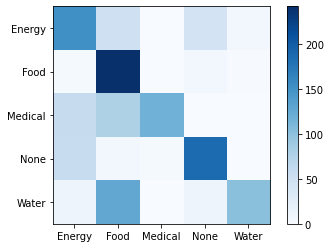

In [27]:
lib.show_confusion_matrix(results["predictions"])

In the matrix, the **rows** correspond to the **true category** and the **columns** correspond to the **predicted category**.

### Visualizing individual tweets

It can also be really useful to visualize the probabilities of each token in an individual tweet. This can help you understand why a classifier made a correct or wrong prediction. We've implemented a visualization for you so that you can use to inspect how the classifier works on individual tweets.

In [29]:
# The following code visualizes a random tweet from the test data. 
# Hover your mouse over the words!
import random
random_tweet = random.choice(test_tweets)
lib.visualize_tweet(random_tweet, results["prior_probs"], results["token_probs"])

The color of each word tells you for which category $P(\text{token} \mid \text{category})$ is the highest. When you move the mouse over a word, it shows you the actual values of $P(\text{token} \mid \text{category})$ for each category that the classifier uses to make its predictions.

You can also have the classifier make a prediction on your own tweets. Change the text in `my_tweet` below and run the cell below to see what the classifier would predict.

In [30]:
my_tweet = "I urgently need some bottled water."

lib.visualize_tweet(lib.Tweet(my_tweet, "?", ""), results["prior_probs"], results["token_probs"])